# (WI4650) CodeLab 7 - QML
### Problem: QML for ordinary differential equations

In this Codelab you will learn how to implement a QML for the ordinary differential equation (ODE) $\frac{df}{dx}=4x^3+x^2-2x-\frac122$ with $f(0)=1$ using Qadence.

To get started, please do the following:
1. Install [Qadence](https://pasqal-io.github.io/qadence/latest/) and some additional Python packages: `pip install jupyterlab qadence`
2. Start JubyterLab: `jupyter lab`

### A working QML example

Qadence is yet another quantum programming package that is particularly useful for developing QML applications.

In [1]:
# General imports
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import uniform
from qadence import *
from torch import nn, optim, tensor, zeros_like, ones_like, linspace, manual_seed
from torch.autograd import grad

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
INFO  2024-06-18 16:01:36 - pyqtorch: PyQTorch logger successfully setup with log level 20


Let us define some global parameters. You can later change these parameters to study how less or more qubits or a deeper quantum network influences the QML's performance.

In [3]:
manual_seed(42) #  random seed
N_QUBITS, DEPTH, LEARNING_RATE, N_POINTS = 6, 5, 0.01, 20

An essential part of a QML is the **ansatz**, that is, a parametric circuit whose parameters will be trained. 
Let us use the **hardware-efficient ansatz** (`hea`)

In [4]:
ansatz = hea(n_qubits=N_QUBITS, depth=DEPTH)

The other important part is the **feature map**, which encodes the input of our quantum network into the quantum circuit. Here, we use the **Chebyshev feature map**

In [5]:
fm = feature_map(n_qubits=N_QUBITS, param="x", fm_type = BasisSet.CHEBYSHEV)

Next, we need to define a **cost function**. Don't confuse this with the loss function that encodes our ODE. Let us choose the **transverse-field Ising Hamiltonian**

In [6]:
obs = zz_hamiltonian(n_qubits=N_QUBITS)

Now we are ready to build the *quantum circuit* and the **QNN model**

In [7]:
circuit = QuantumCircuit(N_QUBITS, chain(fm, ansatz))
model = QNN(circuit=circuit, observable=obs, inputs=["x"])

Let us turn to the classical part of the QNN. First, we need to choose an **optimizer**. Here, we use Adam

In [8]:
opt = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Next, we need to implement the **loss function**. In our case, we implement the MSE loss function for the ODE $\frac{df}{dx}=4x^3+x^2-2x-1/2$ with $f(0)=1$

In [11]:
def loss_fn(inputs: tensor, outputs: tensor) -> tensor:
    dfdx = grad(inputs=inputs, outputs=outputs.sum(), create_graph=True)[0]
    ode_loss = dfdx + 8*outputs*(0.1+tensor(np.tan(8*inputs.detach().numpy())))
    boundary_loss = model(zeros_like(inputs)) - ones_like(inputs)
    return ode_loss.pow(2).mean() + boundary_loss.pow(2).mean()

Let us train the QNN for 1000 epochs with randomly samples collocation points between (-1.0, 1.0)

In [12]:
for epoch in range(250):
    opt.zero_grad()

    # the collocation points are sampled randomly
    cp = tensor(
        uniform(low=0, high=6.28, size=(N_POINTS, 1)), requires_grad=True
    ).float()
    
    loss = loss_fn(inputs=cp, outputs=model(cp))
    
    if (epoch % 50 == 0):
        print(epoch, loss.item())
        
    loss.backward()
    opt.step()

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

To compare the quality of the learned solution, we also create the analytic one

In [46]:
sample_points = linspace(-1.0, 1.0, steps=100).reshape(-1, 1)
analytic_sol = (
    sample_points**4
    + (1 / 3) * sample_points**3
    - sample_points**2
    - (1 / 2) * sample_points
    + 1
)

Now, let us evaluate the solution predicted by the QNN

In [47]:
dqc_sol = model(sample_points).detach().numpy()
x_data = sample_points.detach().numpy()

As a last step, let's have a look at the two solutions

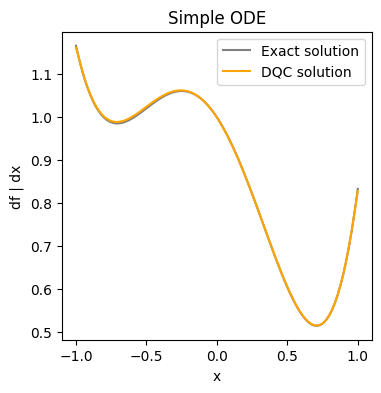

In [48]:
plt.figure(figsize=(4, 4))
plt.plot(x_data, analytic_sol.flatten(), color="gray", label="Exact solution")
plt.plot(x_data, dqc_sol.flatten(), color="orange", label="DQC solution")
plt.xlabel("x")
plt.ylabel("df | dx")
plt.title("Simple ODE")
plt.legend()
plt.show()

### Part A)

Now it's your turn to explore the influence of the different parts on the QNN's performance.

**A1)** Increase/decrease the number of qubits (`N_QUBITS`) and leave all other parameters unchanged. Does this change the performance of the QNN?

**A2)** Increase/decrease the depth of the ansatz (`DEPTH`) and leave all other parameters unchanged. Does this change the performance of the QNN?

**A3)** Try the Fourier feature maps (`BasisSet.FOURIER`) as an alternative to the Chebyshev one. Does this change the performance of the QNN?

**A4)** Try one of the other optimizers, e.g., `optim.LBFGS`, `optim.RMSprop`, or `optim.SGD`. Does this change speed of the training process?

### Part B)

In this part, you will implement a QNN for a different ODE, namely, $\frac{df}{dy}=\cos(x)$ with $y(0)=0$